# SI 618 - Homework 7 - Clustering Bob Ross paintings using k-means

## Objectives
* Practice k-means clustering
* Gain experience moving between pandas and Spark (both ways)

## Please fill in...
### * Your name: Raphael Ku
### * People you worked with:  I worked by myself

## Submission Instructions:
Please turn in this Databricks notebook in HTML format as well as the URL to the published version of this notebook via Canvas.

### NOTE: BECAUSE WE ARE USING THE (FREE) COMMUNITY EDITION OF DATABRICKS, YOU WILL NEED TO CLONE A TERMINATED CLUSTER TO RUN THIS NOTEBOOK.  Please see https://www.youtube.com/watch?v=0p9jfZSESG8 for details on how to do this.

## Background
### Bob Ross
For this particular exercise we're going to use k-means clustering to analyse Bob Ross paintings.  I was inspired by the FiveThirtyEight article on his work, which you should read for background:

https://fivethirtyeight.com/features/a-statistical-analysis-of-the-work-of-bob-ross/

For those of you unfamiliar with Bob ("Happy Trees") Ross... check out his videos on YouTube (e.g. https://www.youtube.com/watch?v=kJFB6rH3z2A) and the Wikipedia page on him.  We're going to use the data provided by fivethirtyeight but will also augment it with the actual images. We've downloaded a few hundred thumbnails and will use those as well.

**NOTE:** Do not attempt to just run this entire notebook.  Read over each step before you run it and try to understand what's going on.

### CODE FOR DATA PREPARATION AND THE FIRST K-MEANS ANALYSIS IS DONE FOR YOU!
You should study and attempt to understand the code before you move on to 
completing parts 2-6 (and, optionally, one of the "Above and Beyond" tasks).

### As a first step, let's load the libraries we need:

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import matplotlib.cm as cm
import re
import os.path

### Getting the data from Amazon Web Services S3

We need the CSV file with data (bob_ross.csv), as well as a collection of images to complete this assignment.
One way for us to share those with you is to put them in an AWS S3 bucket and get you to "mount" that bucket
as a directory that's accessible via this notebook.

The following code block does exactly that, making the bucket containing those files available to this notebook.  To Spark, it will look like the files live in a directory called ```/mnt/si330w18```.  
To pandas, which we will use to read the data, the files will live in ```/dbfs/mnt/si330w18```.  Note the use of ```/dbfs``` as a prefix in the pandas version.

You should be able to just run the next code block.  At the end of the code block is a command to list the contents of the 
mounted S3 bucket.

In [8]:
ACCESS_KEY = ""
SECRET_KEY = ""
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
AWS_BUCKET_NAME = ""
MOUNT_NAME = ""
try:
  dbutils.fs.unmount("/mnt/%s/" % MOUNT_NAME)
except:
  print("Could not unmount %s, but that's ok." % MOUNT_NAME)
dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/umsi-data-science/si618wn2017"))

path,name,size
dbfs:/mnt/umsi-data-science/si618wn2017/bob_ross.csv,bob_ross.csv,66316
dbfs:/mnt/umsi-data-science/si618wn2017/emails.csv,emails.csv,1426122219
dbfs:/mnt/umsi-data-science/si618wn2017/grimmlines.txt,grimmlines.txt,549482
dbfs:/mnt/umsi-data-science/si618wn2017/images/,images/,0
dbfs:/mnt/umsi-data-science/si618wn2017/mail.parquet,mail.parquet,554902149


### Defining a helper function to simplify the color space of images
The next code block sets up a utility function (```getColors```), which takes an image and figures out which colors are used.
It reduces the color space to about 85 colors (from an original space of 65536 colors) and returns the normalized count of 
each color's appearance in the image.

The function takes as input the filename of an image file.  It opens the file and sets up a numpy array of zeros for each of the
85 output colors.  The function then goes through all of the pixels in the image and calculates the red, green and blue 
color values in the reduced space (that's why we divide each of the values for red, green and blue by 63).  We then put
the red, green and blue values back together again by bit-shifting the green and blue values and then using a logical 'or'.
Let's say we had a color of 126,189,252 (which is an pleasant blue color).  Dividing those values by 63, we get 2,3,4.
Bit-shifting 3 << 2 gives us 12, 4 << 4 gives us 64.  We don't bit-shift the red values, so we just keep the 2.  Adding those
together (equivalent to using a logical "or" on the bit-shifted values) gives us 78, so we would increment the count of color 78.

Finally, we convert all counts to proportions and return the proportions of each color as a numpy array.

In [10]:
def getColors(img):
    im = Image.open(img, 'r')
    width, height = im.size
    #print(img,width,height)
    pixel_values = list(im.getdata())
    cnt = np.zeros(85,dtype=int)
    for i in pixel_values:
        #print(i)
        r = int(i[0]/63)
        g = int(i[1]/63)<<2
        b = int(i[2]/63)<<4
        x = r | g | b
        #print(x)
        cnt[x] = cnt[x] + 1
        #print(cnt[x])
    cnt = cnt/float(sum(cnt))
    return(cnt)

### Loading the "tags' file into a pandas DataFrame
First, we're going to load the CSV file of the human-assigned tags for each of Bob's paintings into a **pandas** DataFrame.  Remember that we mounted the AWS S3 bucket containing the data as ```/mnt/umsi-data-science/si618wn2017``` and the CSV file is named ```bob_ross.csv```.  We can read the file using the (hopefully)
familiar ```.from_csv()``` method in pandas:

In [12]:
bob_ross = pd.DataFrame.from_csv("/dbfs/mnt/umsi-data-science/si618wn2017/bob_ross.csv")

Let's take a look at the contents:

In [14]:
bob_ross.head()

Out[ 209 ]: 
 TITLE APPLE_FRAME AURORA_BOREALIS BARN BEACH \
EPISODE 
S01E01 "A WALK IN THE WOODS" 0 0 0 0 
S01E02 "MT. MCKINLEY" 0 0 0 0 
S01E03 "EBONY SUNSET" 0 0 0 0 
S01E04 "WINTER MIST" 0 0 0 0 
S01E05 "QUIET STREAM" 0 0 0 0 

 BOAT BRIDGE BUILDING BUSHES CABIN ... TOMB_FRAME TREE \
EPISODE ... 
S01E01 0 0 0 1 0 ... 0 1 
S01E02 0 0 0 0 1 ... 0 1 
S01E03 0 0 0 0 1 ... 0 1 
S01E04 0 0 0 1 0 ... 0 1 
S01E05 0 0 0 0 0 ... 0 1 

 TREES TRIPLE_FRAME WATERFALL WAVES WINDMILL WINDOW_FRAME \
EPISODE 
S01E01 1 0 0 0 0 0 
S01E02 1 0 0 0 0 0 
S01E03 1 0 0 0 0 0 
S01E04 1 0 0 0 0 0 
S01E05 1 0 0 0 0 0 

 WINTER WOOD_FRAMED 
EPISODE 
S01E01 0 0 
S01E02 1 0 
S01E03 1 0 
S01E04 0 0 
S01E05 0 0 

[5 rows x 68 columns]

The above command should show you that you have a pandas DataFrame with 5 rows and 68 columns.  These are the "tags" for each of the images that
we will load.  The tags were generated by people, and indicate the presence or absence of various features (e.g. "BEACH"), which is set to 1 if the 
feature is present or 0 if the feature is not present.

## NOTE: The next code block takes a very long time (about 5 minutes) to complete.  Wait for it!

In [17]:
bob_ross['image'] = ""
# create a column for each of the 85 colors (these will be c0...c84)
# we'll do this in a separate table for now and then merge
cols = ['c%s'%i for i in np.arange(0,85)]
colors = pd.DataFrame(columns=cols)
colors['EPISODE'] = bob_ross.index.values
colors = colors.set_index('EPISODE')

# figure out if we have the image or not, we don't have a complete set
for s in bob_ross.index.values:
    b = bob_ross.loc[s]['TITLE']
    b = b.lower()
    b = re.sub(r'[^a-z0-9\s]', '',b)
    b = re.sub(r'\s', '_',b)
    img = b+".png"
    if (os.path.exists("/dbfs/mnt/umsi-data-science/si618wn2017/images/"+img)):
        bob_ross.set_value(s,"image","/dbfs/mnt/umsi-data-science/si618wn2017/images/"+img)
        t = getColors("/dbfs/mnt/umsi-data-science/si618wn2017/images/"+img)
        colors.loc[s] = t


In [18]:
# join the colors and tag database and toss the rows where we don't have an image
bob_ross = bob_ross.join(colors)
bob_ross = bob_ross[bob_ross.image != ""] 

In [19]:
# these are masks you might find handy to only get the colors, the tags, or both (as well as the image path)
color_columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10',
               'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20',
               'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30',
               'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40',
               'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50',
               'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60',
               'c61', 'c62', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68', 'c69', 'c70',
               'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80',
               'c81', 'c82', 'c83', 'c84']
tag_columns = ['APPLE_FRAME', 'AURORA_BOREALIS', 'BARN', 'BEACH', 'BOAT',
       'BRIDGE', 'BUILDING', 'BUSHES', 'CABIN', 'CACTUS', 'CIRCLE_FRAME',
       'CIRRUS', 'CLIFF', 'CLOUDS', 'CONIFER', 'CUMULUS', 'DECIDUOUS',
       'DIANE_ANDRE', 'DOCK', 'DOUBLE_OVAL_FRAME', 'FARM', 'FENCE', 'FIRE',
       'FLORIDA_FRAME', 'FLOWERS', 'FOG', 'FRAMED', 'GRASS', 'GUEST',
       'HALF_CIRCLE_FRAME', 'HALF_OVAL_FRAME', 'HILLS', 'LAKE', 'LAKES',
       'LIGHTHOUSE', 'MILL', 'MOON', 'MOUNTAIN', 'MOUNTAINS', 'NIGHT', 'OCEAN',
       'OVAL_FRAME', 'PALM_TREES', 'PATH', 'PERSON', 'PORTRAIT',
       'RECTANGLE_3D_FRAME', 'RECTANGULAR_FRAME', 'RIVER', 'ROCKS',
       'SEASHELL_FRAME', 'SNOW', 'SNOWY_MOUNTAIN', 'SPLIT_FRAME', 'STEVE_ROSS',
       'STRUCTURE', 'SUN', 'TOMB_FRAME', 'TREE', 'TREES', 'TRIPLE_FRAME',
       'WATERFALL', 'WAVES', 'WINDMILL', 'WINDOW_FRAME', 'WINTER',
       'WOOD_FRAMED']
all_columns = color_columns + tag_columns + ['image']
color_columns = color_columns + ['image']
tag_columns = tag_columns + ['image']

In [20]:
# this is a utility function for displaying a grid of images, with an optional heading
def display_images(imagelist,cluster_title=None):
    a = imagelist.apply(lambda x: re.search('(\w+.png)', x).group(1))
    np.zeros(7-len(a)%7,dtype=np.str)
    a = np.append(a,np.zeros(7-len(a)%7,dtype=np.str))
    grid = a.reshape(int(len(a)/7),7)
    text = ""
    if (cluster_title != None):
       text = "<h1>"+cluster_title+"</h1>\n" 
    text = text + "<table>"
    for i in np.arange(0,len(grid)):
        row = grid[i]
        line = ''.join( ["\n<TD><img style='width: 120px; margin: 0px; float: left; border: 1px solid black;' src='https://s3.amazonaws.com/si618image/images/%s' /></TD>" % str(s) for s in row])
        text = text + "<TR>"+line+"</TR>\n"
    text = text +"</table>"
    displayHTML(text)

In [21]:
# for example, we can display the first 12 images
display_images(bob_ross.image,"sample images")

sample images

## K-means
### 1) K-Means on tags (2 clusters)

We're going to start by replicating the fivethirtyeight article a bit.  Using *only* the tags, perform a k-means clustering with 2 clusters. Use display_images to show the images from each cluster.

**We are going to move our data into Spark for this analysis.**

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

tags = spark.createDataFrame(bob_ross[tag_columns[:-1]])

assembler = VectorAssembler(
    inputCols=tag_columns[:-1],
    outputCol="features")

tags_assembled = assembler.transform(tags)


# create a k-means model, k=2, and fit the data
kmeans = KMeans().setK(2).setSeed(1)
kmeans_model = kmeans.fit(tags_assembled.select("features"))

# Make predictions
tags_predictions = kmeans_model.transform(tags_assembled)

### Now move back into pandas...

In [25]:
bob_ross["prediction"] = tags_predictions.select("prediction").toPandas().set_index(bob_ross.index)

df_0 = bob_ross[bob_ross["prediction"] == 0]
display_images(df_0['image']," Cluster 1 Images")

Cluster 1 Images

In [26]:
df_1 = bob_ross[bob_ross["prediction"] == 1]
display_images(df_1['image'],"Cluster 2 Images")

Cluster 2 Images

### 2) Describe the differences

Without any further analysis, is there something obviously different about what's in the images?

**Your answer**: Cluster 1 seems to have fixated on the presence of mountains in Bob Ross's paintings, while Cluster 2 paintings usually will not have any mountains as part of the painting.

### 3) Calculate the differences between clusters

One thing we can do to compare the clusters is to determine which tags show up more in the first cluster and which ones appear more in the second. Write code to determine which tags are maximally different between the two clusters.  You should get output that looks like:
```
MOUNTAIN              0.967647
SNOWY_MOUNTAIN        0.681513
MOUNTAINS             0.638655
CONIFER               0.515126
LAKE                  0.294958
```

Hint: you can do this with some combination of masks, .mean() and .sort_values() all in one line (but feel free to write a loop if it's easier to think about)

In [29]:
clust1 = bob_ross[bob_ross['prediction'] == 0].mean().sort_values(ascending=False).drop('prediction', axis=0)
clust2 = bob_ross[bob_ross['prediction'] == 1].mean().sort_values(ascending=False).drop('prediction', axis=0)
comparative = pd.DataFrame(data={'Cluster_1':clust1, 'Cluster_2':clust2})
comparative['diff'] = comparative.Cluster_1 - comparative.Cluster_2
comparative.sort_values(by='diff', ascending=False)

Out[ 218 ]: 
 Cluster_1 Cluster_2 diff
MOUNTAIN 0.992857 0.025210 0.967647
SNOWY_MOUNTAIN 0.685714 0.004202 0.681513
MOUNTAINS 0.642857 0.004202 0.638655
CONIFER 0.842857 0.327731 0.515126
LAKE 0.542857 0.247899 0.294958
BUSHES 0.407143 0.214286 0.192857
TREES 0.935714 0.768908 0.166807
TREE 0.985714 0.831933 0.153782
CLOUDS 0.535714 0.394958 0.140756
CUMULUS 0.292857 0.155462 0.137395
CIRRUS 0.107143 0.046218 0.060924
GRASS 0.392857 0.344538 0.048319
STEVE_ROSS 0.057143 0.012605 0.044538
GUEST 0.078571 0.046218 0.032353
SPLIT_FRAME 0.007143 0.000000 0.007143
TOMB_FRAME 0.007143 0.000000 0.007143
RECTANGLE_3D_FRAME 0.007143 0.000000 0.007143
DIANE_ANDRE 0.007143 0.000000 0.007143
TRIPLE_FRAME 0.007143 0.000000 0.007143
DOUBLE_OVAL_FRAME 0.007143 0.000000 0.007143
HALF_OVAL_FRAME 0.007143 0.000000 0.007143
WOOD_FRAMED 0.007143 0.000000 0.007143
WATERFALL 0.107143 0.100840 0.006303
WINTER 0.164286 0.159664 0.004622
AURORA_BOREALIS 0.007143 0.004202 0.002941
LAKES 0.000000 0.000000 0.000000
MOON 0.007143 0.008403 -0.001261
RIVER 0.321429 0.323529 -0.002101
APPLE_FRAME 0.000000 0.004202 -0.004202
RECTANGULAR_FRAME 0.000000 0.004202 -0.004202
... ... ... ...
FIRE 0.000000 0.004202 -0.004202
FLORIDA_FRAME 0.000000 0.004202 -0.004202
HALF_CIRCLE_FRAME 0.000000 0.004202 -0.004202
SEASHELL_FRAME 0.000000 0.004202 -0.004202
CACTUS 0.007143 0.012605 -0.005462
CIRCLE_FRAME 0.000000 0.008403 -0.008403
BOAT 0.000000 0.008403 -0.008403
MILL 0.000000 0.008403 -0.008403
NIGHT 0.021429 0.033613 -0.012185
FLOWERS 0.021429 0.033613 -0.012185
PORTRAIT 0.000000 0.012605 -0.012605
FOG 0.050000 0.063025 -0.013025
SNOW 0.164286 0.184874 -0.020588
HILLS 0.028571 0.054622 -0.026050
BRIDGE 0.000000 0.029412 -0.029412
FRAMED 0.114286 0.147059 -0.032773
CLIFF 0.000000 0.033613 -0.033613
PALM_TREES 0.000000 0.037815 -0.037815
OVAL_FRAME 0.064286 0.113445 -0.049160
BARN 0.000000 0.067227 -0.067227
CABIN 0.121429 0.197479 -0.076050
FENCE 0.007143 0.088235 -0.081092
SUN 0.035714 0.130252 -0.094538
PATH 0.057143 0.155462 -0.098319
ROCKS 0.135714 0.235294 -0.099580
BEACH 0.000000 0.109244 -0.109244
WAVES 0.000000 0.134454 -0.134454
OCEAN 0.000000 0.142857 -0.142857
STRUCTURE 0.114286 0.264706 -0.150420
DECIDUOUS 0.400000 0.651261 -0.251261

[67 rows x 3 columns]

### 4) Find a better value of k

Determine a better value for k (you can use the "rule of thumb" approach, silhoutte scores, or scree plots... though as a warning, some of these may not be as "clear" as the examples in class).  

**Use display_images to show the different clusters, pick the best value of k, and describe your clusters qualitatively.**

In [31]:
# method 1: "Rule of Thumb"
guess = np.sqrt(tags_predictions.count()/2)
print("Rule of thumb method suggests {} clusters".format(guess))
# print the results

Rule of thumb method suggests 13.74772708486752 clusters

In [32]:
# method 2: Scree plot
cost = list()
for k in range(2,11):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(tags_assembled)
    cost.append(bkm_model.computeCost(tags_assembled))

# print the results

In [33]:
fig, ax = plt.subplots()
plt.plot(range(2,11), cost, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Within Set Sum of Squared Error');
plt.title('Elbow for K-Means clustering');
# Uncomment the next line
# display(fig)

Out[ 221 ]: <matplotlib.text.Text at 0x7ff1c2b2c1d0>

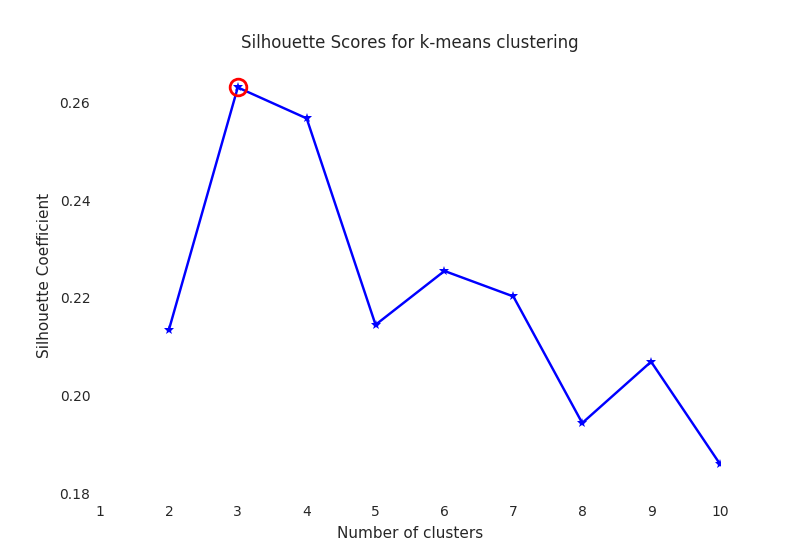

In [34]:
# method 3: Silhouette scores
cost = list()
evaluator = ClusteringEvaluator()
for k in range(2,11):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(tags_assembled)
    tags_predictions = bkm_model.transform(tags_assembled)
    silhouette = evaluator.evaluate(tags_predictions)
    cost.append(silhouette)
    
kIdx = np.argmax(cost)

fig, ax = plt.subplots()
plt.plot(range(2,11), cost, 'b*-')
plt.plot(range(2,11)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

In [35]:
# create a k-means model, k=2, and fit the data
kmeans_new = KMeans().setK(3).setSeed(1)
kmeans_model_new = kmeans_new.fit(tags_assembled.select("features"))

# Make predictions
newk_predictions = kmeans_model_new.transform(tags_assembled)

In [36]:
newk_df = bob_ross
newk_df['prediction'] = newk_predictions.select('prediction').toPandas().set_index(newk_df.index)
display_images(newk_df[newk_df['prediction'] == 0]['image'], 'Cluster 1')

Cluster 1

In [37]:
display_images(newk_df[newk_df['prediction'] == 1]['image'], 'Cluster 2')

Cluster 2

In [38]:
display_images(newk_df[newk_df['prediction'] == 2]['image'], 'Cluster 3')

Cluster 3

### Findings
Based on the silhouette plot, the optimal k for clustering paintings based on the image tags as features would be 3. Using 3 clusters, Cluster 1 tends to feature a body of water or a face as the primary image tag dominating the painting. Cluster 2 tends to have buildings, like old sheds, as the defining feature of this cluster, but due to its sheer size, several paintings seem to be included her that might have fit the other 2 clusters better. Lastly, Cluster 3 tends to have mountains and trees together as the defining feature.

Comparatively to k=2, k=3 performs better in that it doesn't seem to be a binary distinction anymore on based on the presence/absence of mountains. Instead, the clusters seem to be defined based on a specific set of image tags.

### 5) k-means based on colors
Perform k-means clustering on the paintings using *only* the color columns. Decide a good value for k, execute the clustering, display the images in each clusters, and describe the resulting clusters.

In [41]:
coltag = spark.createDataFrame(bob_ross[color_columns[:-1]])

col_assembler = VectorAssembler(
    inputCols=color_columns[:-1],
    outputCol="features")

assembled_coltag = col_assembler.transform(coltag)

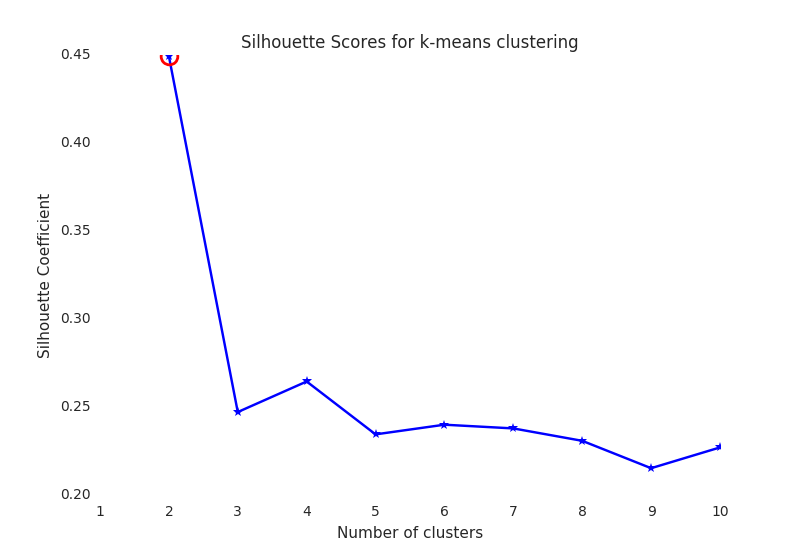

In [42]:
#Selecting k
cost = list()
evaluator = ClusteringEvaluator()
for k in range(2,11):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(assembled_coltag)
    coltag_pred = bkm_model.transform(assembled_coltag)
    silhouette = evaluator.evaluate(coltag_pred)
    cost.append(silhouette)
    
kIdx = np.argmax(cost)

fig, ax = plt.subplots()
plt.plot(range(2,11), cost, 'b*-')
plt.plot(range(2,11)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

In [43]:
col_kmeans = KMeans().setK(2).setSeed(1)
col_kmeans_model = col_kmeans.fit(assembled_coltag.select("features"))
colorprediction = col_kmeans_model.transform(assembled_coltag)
color_df = bob_ross
color_df['prediction'] = colorprediction.select('prediction').toPandas().set_index(color_df.index)
display_images(color_df[color_df['prediction'] == 0]['image'], 'Cluster 1')

Cluster 1

In [44]:
display_images(color_df[color_df['prediction'] == 1]['image'], 'Cluster 2')

Cluster 2

### Findings
Based on the silhouette plot, the optimal number of clusters seem to be 2. Using that as the number of clusters to be used, I find that the clusters are different in terms of lighting, so to speak. Cluster 1 tends to have a focus on darker paintings, with a predominant use of black, blue, and dark green. On the other hand, Cluster 2 tends to have more colorful and bright paintings, where predominant colors tend to be white, yellow, and orange.

### 6) Use both tags and colors for k-means clustering

Perform k-means clustering on the paintings using *both* tag and color columns. Decide a good value for k, execute the clustering, display the images in each clusters, and describe the resulting clusters.

In [47]:
alltag = spark.createDataFrame(bob_ross[all_columns[:-1]])

all_assembler = VectorAssembler(
    inputCols=all_columns[:-1],
    outputCol="features")

assembled_alltag = all_assembler.transform(alltag)

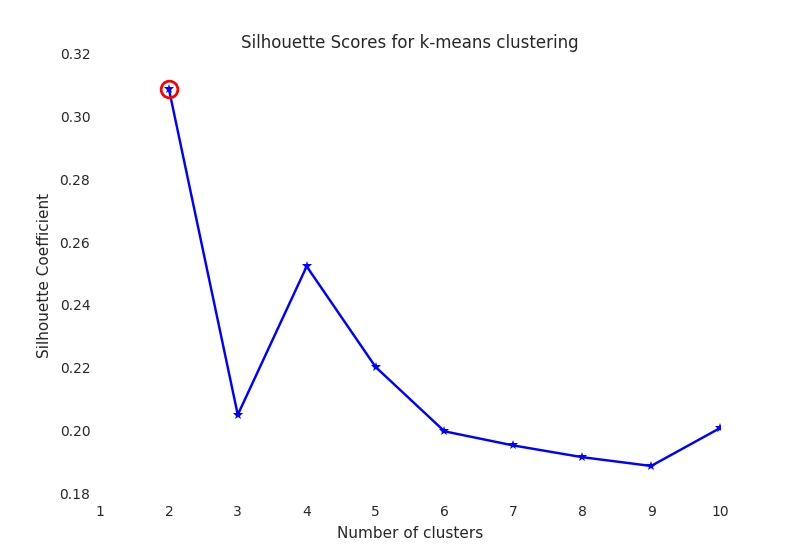

In [48]:
#Selecting k
cost = list()
evaluator = ClusteringEvaluator()
for k in range(2,11):
    bkm = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    bkm_model = bkm.fit(assembled_alltag)
    alltag_pred = bkm_model.transform(assembled_alltag)
    silhouette = evaluator.evaluate(alltag_pred)
    cost.append(silhouette)
    
kIdx = np.argmax(cost)

fig, ax = plt.subplots()
plt.plot(range(2,11), cost, 'b*-')
plt.plot(range(2,11)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

In [49]:
all_kmeans = KMeans().setK(4).setSeed(1)
all_kmeans_model = all_kmeans.fit(assembled_alltag.select("features"))
allprediction = all_kmeans_model.transform(assembled_alltag)
all_df = bob_ross
all_df['prediction'] = allprediction.select('prediction').toPandas().set_index(all_df.index)
display_images(all_df[all_df['prediction'] == 0]['image'], 'Cluster 1')

Cluster 1

In [50]:
display_images(all_df[all_df['prediction'] == 1]['image'], 'Cluster 2')

Cluster 2

In [51]:
display_images(all_df[all_df['prediction'] == 2]['image'], 'Cluster 3')

Cluster 3

In [52]:
display_images(all_df[all_df['prediction'] == 3]['image'], 'Cluster 4')

Cluster 4

In [53]:
memory = all_df[all_df['prediction'] == 3].mean().drop('prediction', axis=0).sort_values(ascending=False)

### Findings
Based on the silhouette plot, the optimal number of clusters seem to be 2, but given the number of tags involved, as well as the silhouette plot indicating a 2nd peak in silhouette score, I chose to use k to be 4 to better represent the dataset. 

Cluster 1 seems to require the presence of snow and buildings

Cluster 2 seems to require the presence of mountains, with no real color preference 

Cluster 3 are forest and tree photos that do not match Cluster 0 and 1, with a strong use of lighter colors, such as yellow and green. 

Lastly, Cluster 4 seems to cluster images that are either faces or a picture of the sea and waves. 

Based on this, although it might not be the clustering with the best silhouette score, the clusters seem distinct enough with k as 4, with a small issue of intersection between cluster 1 and 2, since some of cluster 1's paintings do contain a mountain as well. Also, due to this clustering, it seems that the painting subject lists may be more effective in clustering similar paintings, given that the clustering focuses more on subjects rather than color.

## Above and Beyond
Completing the above tasks will earn you up to 64 of the 80 points available for this assignment.  Completing one (and only one) of the following tasks will earn **up to** 16 additional points.  Please review the details of scaling "Above and Beyond" points from the previous homework assignment to understand how these points will be used in the 
calculation of your final point score in this course.
1. Use Spark to load the CSV and image data, and to create the color columns (i.e. do not use pandas until below the k-means analysis).  How much more efficient (in terms of time taken) is your Spark-based solution compared to the pandas-based approach?
2. Repeat the analysis for Step 6 (both tags and colors) using bisecting k-means **and compare the results to k-means**. Describe, in detail, how the resulting clusters differ.  The majority of your work should go into exploring the differences in the results.

In [56]:
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
copy = assembled_alltag

bisectall = BisectingKMeans().setK(4).setSeed(1)
all_model = bisectall.fit(copy)
bkmprediction = all_model.transform(copy)

In [57]:
bkm_df = bob_ross
bkm_df['prediction'] = bkmprediction.select('prediction').toPandas().set_index(bkm_df.index)
display_images(bkm_df[bkm_df['prediction'] == 0]['image'], 'Cluster 1')

Cluster 1

In [58]:
review1 = pd.DataFrame(data={'BKM' : bkm_df[bkm_df['prediction'] == 0].mean().drop('prediction', axis=0), 'KMean' : memory})
review1['diff'] = review1.BKM - review1.KMean
review1.sort_values(by='diff', ascending=False)

Out[ 258 ]: 
 BKM KMean diff
OCEAN 0.755556 0.739130 0.016425
WAVES 0.711111 0.695652 0.015459
BEACH 0.577778 0.565217 0.012560
ROCKS 0.444444 0.434783 0.009662
CUMULUS 0.333333 0.326087 0.007246
SUN 0.222222 0.217391 0.004831
PALM_TREES 0.200000 0.195652 0.004348
FRAMED 0.155556 0.152174 0.003382
GUEST 0.133333 0.130435 0.002899
CLIFF 0.133333 0.130435 0.002899
OVAL_FRAME 0.133333 0.130435 0.002899
TREE 0.111111 0.108696 0.002415
GRASS 0.111111 0.108696 0.002415
NIGHT 0.088889 0.086957 0.001932
TREES 0.088889 0.086957 0.001932
PORTRAIT 0.066667 0.065217 0.001449
HILLS 0.066667 0.065217 0.001449
FENCE 0.044444 0.043478 0.000966
DECIDUOUS 0.044444 0.043478 0.000966
CONIFER 0.044444 0.043478 0.000966
SEASHELL_FRAME 0.022222 0.021739 0.000483
BARN 0.022222 0.021739 0.000483
BOAT 0.022222 0.021739 0.000483
FLORIDA_FRAME 0.022222 0.021739 0.000483
FLOWERS 0.022222 0.021739 0.000483
MOON 0.022222 0.021739 0.000483
STRUCTURE 0.022222 0.021739 0.000483
LIGHTHOUSE 0.022222 0.021739 0.000483
RIVER 0.000000 0.000000 0.000000
WINTER 0.000000 0.000000 0.000000
... ... ... ...
TRIPLE_FRAME 0.000000 0.000000 0.000000
SNOWY_MOUNTAIN 0.000000 0.000000 0.000000
SPLIT_FRAME 0.000000 0.000000 0.000000
PERSON 0.000000 0.000000 0.000000
STEVE_ROSS 0.000000 0.000000 0.000000
APPLE_FRAME 0.000000 0.000000 0.000000
LAKES 0.000000 0.000000 0.000000
DOUBLE_OVAL_FRAME 0.000000 0.000000 0.000000
FARM 0.000000 0.000000 0.000000
BRIDGE 0.000000 0.000000 0.000000
BUILDING 0.000000 0.000000 0.000000
BUSHES 0.000000 0.000000 0.000000
CABIN 0.000000 0.000000 0.000000
CIRCLE_FRAME 0.000000 0.000000 0.000000
DIANE_ANDRE 0.000000 0.000000 0.000000
DOCK 0.000000 0.000000 0.000000
WOOD_FRAMED 0.000000 0.000000 0.000000
FIRE 0.000000 0.000000 0.000000
FOG 0.000000 0.000000 0.000000
HALF_CIRCLE_FRAME 0.000000 0.000000 0.000000
HALF_OVAL_FRAME 0.000000 0.000000 0.000000
LAKE 0.000000 0.000000 0.000000
AURORA_BOREALIS 0.000000 0.000000 0.000000
MILL 0.000000 0.000000 0.000000
CLOUDS 0.777778 0.782609 -0.004831
CIRRUS 0.088889 0.108696 -0.019807
CACTUS 0.066667 0.086957 -0.020290
PATH 0.066667 0.086957 -0.020290
MOUNTAIN 0.044444 0.065217 -0.020773
MOUNTAINS 0.000000 0.021739 -0.021739

[67 rows x 3 columns]

In [59]:
display_images(bkm_df[bkm_df['prediction'] == 1]['image'], 'Cluster 2')

Cluster 2

In [60]:
display_images(bkm_df[bkm_df['prediction'] == 2]['image'], 'Cluster 3')

Cluster 3

In [61]:
display_images(bkm_df[bkm_df['prediction'] == 3]['image'], 'Cluster 4')

Cluster 4

In [62]:
review = pd.DataFrame(data={'Cluster3' : bkm_df[bkm_df['prediction'] == 2].mean().drop('prediction', axis=0), 'Cluster4' : bkm_df[bkm_df['prediction'] == 3].mean().drop('prediction', axis=0)})
review['diff'] = review.Cluster3 - review.Cluster4
review.sort_values(by='diff', ascending=False)

Out[ 256 ]: 
 Cluster3 Cluster4 diff
WINTER 0.289855 0.042857 0.246998
SNOW 0.275362 0.057143 0.218219
CABIN 0.188406 0.057143 0.131263
STRUCTURE 0.173913 0.057143 0.116770
FRAMED 0.159420 0.071429 0.087992
OVAL_FRAME 0.101449 0.028571 0.072878
SUN 0.072464 0.000000 0.072464
CONIFER 0.869565 0.814286 0.055280
NIGHT 0.043478 0.000000 0.043478
PATH 0.072464 0.042857 0.029607
TREE 1.000000 0.971429 0.028571
FOG 0.057971 0.042857 0.015114
AURORA_BOREALIS 0.014493 0.000000 0.014493
FENCE 0.014493 0.000000 0.014493
RECTANGLE_3D_FRAME 0.014493 0.000000 0.014493
WOOD_FRAMED 0.014493 0.000000 0.014493
SPLIT_FRAME 0.014493 0.000000 0.014493
TRIPLE_FRAME 0.014493 0.000000 0.014493
MOON 0.014493 0.000000 0.014493
TREES 0.942029 0.928571 0.013458
GRASS 0.391304 0.385714 0.005590
MILL 0.000000 0.000000 0.000000
OCEAN 0.000000 0.000000 0.000000
RECTANGULAR_FRAME 0.000000 0.000000 0.000000
PALM_TREES 0.000000 0.000000 0.000000
PERSON 0.000000 0.000000 0.000000
PORTRAIT 0.000000 0.000000 0.000000
SEASHELL_FRAME 0.000000 0.000000 0.000000
WAVES 0.000000 0.000000 0.000000
WINDMILL 0.000000 0.000000 0.000000
... ... ... ...
BRIDGE 0.000000 0.000000 0.000000
BOAT 0.000000 0.000000 0.000000
BEACH 0.000000 0.000000 0.000000
FARM 0.000000 0.000000 0.000000
DOCK 0.000000 0.000000 0.000000
FLORIDA_FRAME 0.000000 0.000000 0.000000
BARN 0.000000 0.000000 0.000000
HALF_CIRCLE_FRAME 0.000000 0.000000 0.000000
CIRCLE_FRAME 0.000000 0.000000 0.000000
BUSHES 0.405797 0.414286 -0.008489
FLOWERS 0.014493 0.028571 -0.014079
DOUBLE_OVAL_FRAME 0.000000 0.014286 -0.014286
TOMB_FRAME 0.000000 0.014286 -0.014286
DIANE_ANDRE 0.000000 0.014286 -0.014286
HALF_OVAL_FRAME 0.000000 0.014286 -0.014286
CACTUS 0.000000 0.014286 -0.014286
MOUNTAIN 0.985507 1.000000 -0.014493
SNOWY_MOUNTAIN 0.681159 0.700000 -0.018841
MOUNTAINS 0.637681 0.657143 -0.019462
WATERFALL 0.086957 0.114286 -0.027329
LAKE 0.521739 0.571429 -0.049689
RIVER 0.289855 0.342857 -0.053002
HILLS 0.000000 0.057143 -0.057143
ROCKS 0.101449 0.171429 -0.069979
STEVE_ROSS 0.000000 0.114286 -0.114286
DECIDUOUS 0.333333 0.457143 -0.123810
GUEST 0.014493 0.142857 -0.128364
CIRRUS 0.028986 0.185714 -0.156729
CUMULUS 0.000000 0.585714 -0.585714
CLOUDS 0.101449 0.971429 -0.869979

[67 rows x 3 columns]

### Findings
Considering the same k (4) as Question 6, the following differences appeared in the clusters in bisecting k-means vs. regular k-means algorithm:

* Cluster 1: Interestingly, this bisecting k-means cluster seems to be very similar in terrms of Cluster 4 of the regular k-means cluster, in that it's main defining feature is the use of a body of water, or the presence of a face. There are minimal differences in terms of the members. Exploring the average tag usage, Bisecting K-means Cluster 1 is has very minimal differences compared to Question 6's Cluster 4
* Cluster 2: This bisecting k-means cluster is distinctly different compared to the regular k-means algorithm. The main features in this cluster are the presence of trees or structures, which seems to combine the paintings included in Question 6's clusters 1 and 3.
* Unlike the k-mean algorithm applied in Question 6, the last 2 clusters in bisecting k-means don't seem to be as well differentiated with each other. It's clear that Clusters 3 and 4 can be said to be unique compared to cluster 1 and 2, in that you can tell that the prominent feature is the presence of mountains compared to the other clusters. Investigating cluster 3 and 4 in terms of average tag appearance, we see that there isn't a very string differentiating factor, compared to traditional k-means clusters generated in Question 6, where all clusters have distinct differentiating features.